In [1]:
import pandas as pd
import nltk
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json("./articles.json", orient="index")
articles = df["text"].values
titles = df["given_title"].values

In [3]:
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [4]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in articles:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [5]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.8, 
    max_features=200000,
    min_df=0.2, 
    stop_words='english',
    use_idf=True, 
    tokenizer=tokenize_and_stem, 
    ngram_range=(1,3)
)

tfidf_matrix = tfidf_vectorizer.fit_transform(articles) #fit the vectorizer to synopses

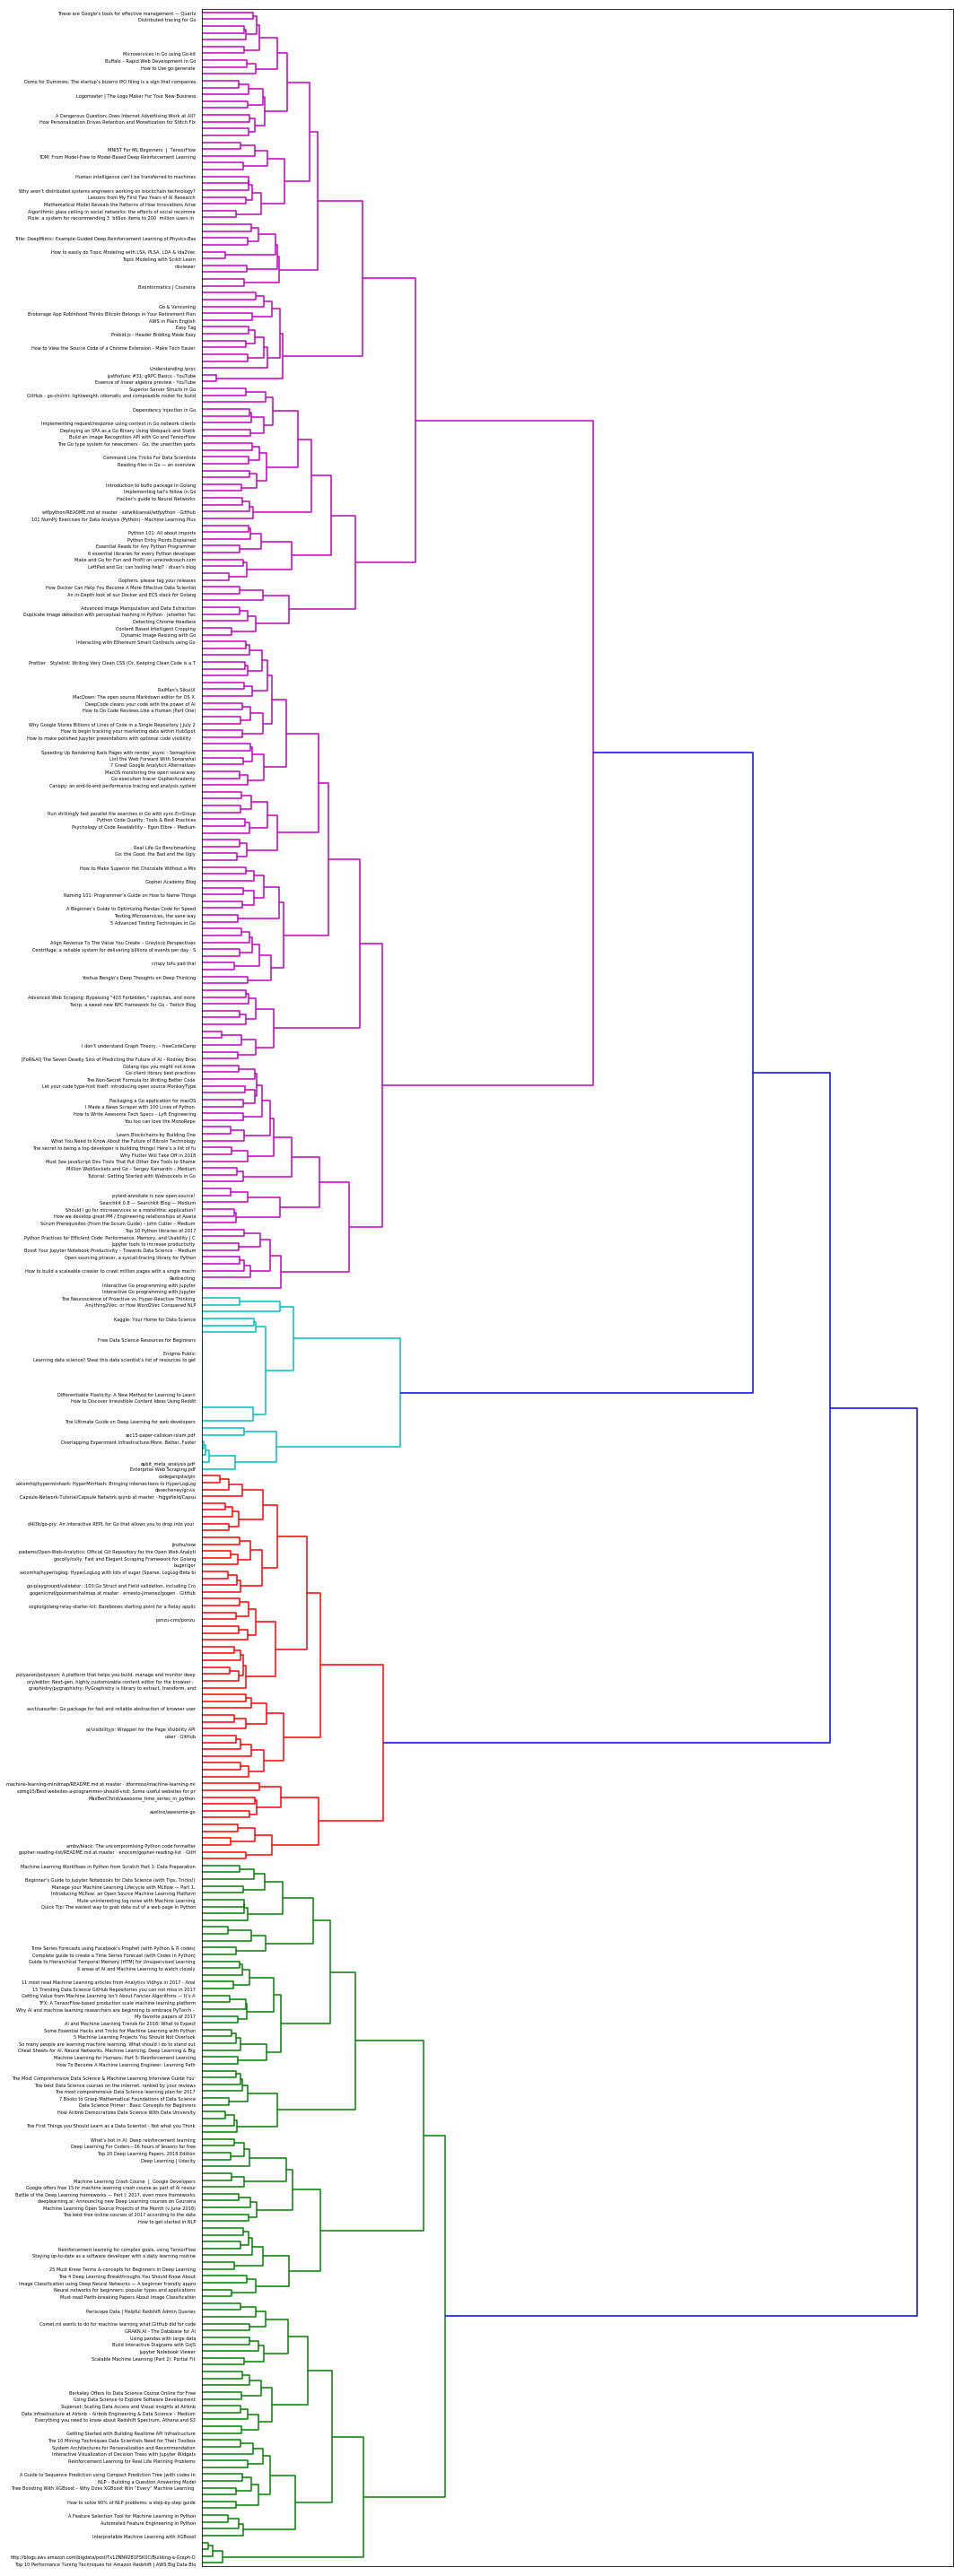

In [6]:
# define the linkage_matrix using ward clustering pre-computed distances
distances = 1 - cosine_similarity(tfidf_matrix)
linkage_matrix = ward(distances)

fig, ax = plt.subplots(figsize=(15, 40)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(
    axis= 'x',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False
)

plt.tight_layout() #show plot with tight layout
plt.savefig('tf_idf_clusters.png', dpi=200)